In [2]:
import snap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import time

# Problem 1

In [3]:
erdosRenyi = None
smallWorld = None
collabNet = None

## Problem 1.1

### Erdos-Renyi Random graph ($G(n, m)$ random network)

In [14]:
def genErdosRenyi(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Erdos-Renyi graph with N nodes and E edges
    """

    # Generate nodes
    Ns = set(range(N))

    # Generate edges
    Es = []
    for _ in range(E):
        i = random.randrange(0, N)
        j = random.randrange(0, N)
        while (i, j) in Es or (j, i) in Es or i == j:
            i = random.randint(0, N)
            j = random.randint(0, N)
        Es.append((i, j))

    # Create undirected graph
    G = snap.TUNGraph.New()

    for NId in Ns:
        G.AddNode(NId)
    
    for src, dst in Es:
        G.AddEdge(src, dst)

    return G

N = 5242
E = 14484

now = time.time()
G = genErdosRenyi(N, E)
print(time.time() - now)

# snap.DrawGViz(G, snap.gvlDot, "erdos-renyi.png", "Erdos-Renyi")

7.519229173660278


### Small-World Random Network

In [15]:
def genCircle(N=5242):
    """
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Circle graph with N nodes and N edges. Imagine the nodes form a
        circle and each node is connected to its two direct neighbors.
    """
    
    # Create an empty undirected graph
    G = snap.TUNGraph.New()

    # Add initial nodes and edges
    G.AddNode(0)
    G.AddNode(1)
    G.AddEdge(0, 1)

    # Iteratively add nodes and edges
    for i in range(2, N):
        G.AddNode(i)
        G.AddEdge(i-1, i)
        G.AddEdge(i-2, i)
    
    # Complete the circle
    G.AddEdge(1, N-1)
    G.AddEdge(0, N-1)
    G.AddEdge(0, N-2)

    return G

N = 5242

now = time.time()
G = genCircle(N)
print(time.time() - now)

# snap.DrawGViz(G, snap.gvlDot, "circle.png", "Circle")

0.00996541976928711


In [16]:
def connectRandomNodes(Graph, M=4000):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :param - M: number of edges to be added

    return type: snap.PUNGraph
    return: Graph object with additional M edges added by connecting M randomly
        selected pairs of nodes not already connected.
    """

    for _ in range(M):
        i = Graph.GetRndNId()
        j = Graph.GetRndNId()
        while i == j or Graph.IsEdge(i, j):
            i = Graph.GetRndNId()
            j = Graph.GetRndNId()
        Graph.AddEdge(i, j)
    return Graph

In [17]:
def genSmallWorld(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Small-World graph with N nodes and E edges
    """
    Graph = genCircle(N)
    Graph = connectRandomNodes(Graph, E-2*N)
    return Graph

N = 5242
E = 14484

now = time.time()
G = genSmallWorld(N, E)
print(time.time() - now)

# snap.DrawGViz(G, snap.gvlDot, "circle.png", "Circle")

0.018586397171020508


### Real-World Collaboration Network

In [18]:
def loadCollabNet(path):
    """
    :param - path: path to edge list file

    return type: snap.PUNGraph
    return: Graph loaded from edge list at `path and self edges removed

    Do not forget to remove the self edges!
    """
    
    G = snap.LoadEdgeList(snap.PUNGraph, path)
    for e in G.Edges():
        src = e.GetSrcNId() 
        dst = e.GetDstNId()
        if src == dst:
            G.DelEdge(src, dst)

    return G

now = time.time()
G = loadCollabNet('data/ca-GrQc.txt')
print(time.time() - now)

0.04683518409729004


### Plot

In [19]:
def getDataPointsToPlot(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    
    X, Y = [], []

    DegToCntV = snap.TIntPrV()
    snap.GetDegCnt(Graph, DegToCntV)
    for item in DegToCntV:
        X.append(item.GetVal1())
        Y.append(item.GetVal2())
    
    total = sum(X)
    Y = [y / total for y in Y]

    return X, Y

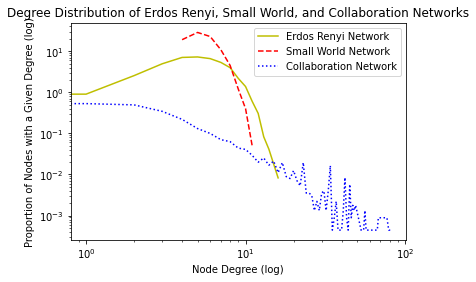

In [20]:
def Q1_1():
    """
    Code for HW1 Q1.1
    """
    global erdosRenyi, smallWorld, collabNet
    erdosRenyi = genErdosRenyi(5242, 14484)
    smallWorld = genSmallWorld(5242, 14484)
    collabNet = loadCollabNet("data/ca-GrQc.txt")

    x_erdosRenyi, y_erdosRenyi = getDataPointsToPlot(erdosRenyi)
    plt.loglog(x_erdosRenyi, y_erdosRenyi, color='y',
               label='Erdos Renyi Network')

    x_smallWorld, y_smallWorld = getDataPointsToPlot(smallWorld)
    plt.loglog(x_smallWorld, y_smallWorld, linestyle='dashed',
               color='r', label='Small World Network')

    x_collabNet, y_collabNet = getDataPointsToPlot(collabNet)
    plt.loglog(x_collabNet, y_collabNet, linestyle='dotted',
               color='b', label='Collaboration Network')

    plt.xlabel('Node Degree (log)')
    plt.ylabel('Proportion of Nodes with a Given Degree (log)')
    plt.title(
        'Degree Distribution of Erdos Renyi, Small World, and Collaboration Networks')
    plt.legend()
    plt.show()
    
Q1_1()

## Problem 1.2

In [21]:
def calcClusteringCoefficientSingleNode(Node, Graph):
    """
    :param - Node: node from snap.PUNGraph object. Graph.Nodes() will give an
                   iterable of nodes in a graph
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: local clustering coeffient of Node
    """

    C = 0.0

    k = Node.GetDeg()
    if k >= 2:
        e = 0.0
        # nbrs = [Node.GetNbrNId(i) for i in range(k)]
        for i in range(k-1):
            for j in range(i+1, k):
                nbr1 = Node.GetNbrNId(i)
                nbr2 = Node.GetNbrNId(j)
                if Graph.IsEdge(nbr1, nbr2):
                    e += 1
        C = 2 * e / (k * (k - 1))

    return C

In [22]:
def calcClusteringCoefficient(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: clustering coeffient of Graph
    """

    C = 0.0
    for NI in Graph.Nodes():
        C += calcClusteringCoefficientSingleNode(NI, Graph)
    C /= Graph.GetNodes()

    return C

calcClusteringCoefficient(erdosRenyi)

0.0011008746224312792

In [23]:
def Q1_2():
    """
    Code for Q1.2
    """
    C_erdosRenyi = calcClusteringCoefficient(erdosRenyi)
    C_smallWorld = calcClusteringCoefficient(smallWorld)
    C_collabNet = calcClusteringCoefficient(collabNet)

    print('Clustering Coefficient for Erdos Renyi Network: %f' % C_erdosRenyi)
    print('Clustering Coefficient for Small World Network: %f' % C_smallWorld)
    print('Clustering Coefficient for Collaboration Network: %f' % C_collabNet)


# Execute code for Q1.2
Q1_2()

Clustering Coefficient for Erdos Renyi Network: 0.001101
Clustering Coefficient for Small World Network: 0.284633
Clustering Coefficient for Collaboration Network: 0.529636
